___Make sure to select the right conda virtual environment before starting execution! You will mess up otherwise!___

In [2]:
# If you got a copy of this notebook from Graham Wheeler, please register for your
# own API keys with Github and Zenhub and replace the next two lines with yours. 

github_token = "your token here"
zenhub_token = "your token here"
github_url = "https://api.github.com"
zenhub_url = "https://api.zenhub.io"

In [ ]:
import sys

In [4]:
# Install requirements that are on PyPI

!{sys.executable} -m pip install pygithub
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install python-dateutil
!{sys.executable} -m pip install pytz

  Using cached https://files.pythonhosted.org/packages/88/0e/9d5a1a8cd7130c49334cce7b8167ceda63d6a329c8ea65b626116bc9e9e6/Deprecated-1.2.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/87/8b/6a9f14b5f781697e51259d81657e6048fd31a113229cf346880bb7545565/PyJWT-1.7.1-py2.py3-none-any.whl
     |████████████████████████████████| 61kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 153kB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 61kB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 143kB 2.9MB/s eta 0:00:01
  Created wheel for wrapt: filename=wrapt-1.11.2-cp37-cp37m-macosx_10_9_x86_64.whl size=32401 sha256=da3145aa653483f892a64dee4ba2f45f32847e5bc3459067968d65130f51c781
  Stored in directory: /Users/grwheele/Library/Caches/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built wrapt


In [3]:
# Update conda

! echo 'y' | conda update -n base conda

Solving environment: done

## Package Plan ##

  environment location: /Users/grwheele/anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anaconda-project-0.8.3     |             py_0         210 KB  conda-forge
    appnope-0.1.0              |           py37_0           8 KB  conda-forge
    astroid-2.2.5              |           py37_0         271 KB  conda-forge
    babel-2.7.0                |             py_0         5.9 MB  conda-forge
    backports-1.0              |             py_2           4 KB  conda-forge
    backports.functools_lru_cache-1.5|             py_1           6 KB  conda-forge
    backports.tempfile-1.0     |             py_0          10 KB  conda-forge
    backports.weakref-1.0.post1|        py37_1000           8 KB  conda-forge
    certifi-2019.6.16          |           py37_0         148 KB  conda-forge
    cloudpi

sphinxcontrib-websup | 33 KB     | ##################################### | 100% 
terminado-0.8.2      | 23 KB     | ##################################### | 100% 
gevent-1.4.0         | 2.3 MB    | ##################################### | 100% 
conda-4.7.10         | 3.0 MB    | ##################################### | 100% 
dask-core-2.1.0      | 573 KB    | ##################################### | 100% 
snowballstemmer-1.9. | 51 KB     | ##################################### | 100% 
conda-package-handli | 257 KB    | ##################################### | 100% 
xlwings-0.15.8       | 457 KB    | ##################################### | 100% 
zipp-0.5.1           | 7 KB      | ##################################### | 100% 
pytest-5.0.1         | 347 KB    | ##################################### | 100% 
jsonschema-3.0.1     | 85 KB     | ##################################### | 100% 
future-0.17.1        | 696 KB    | ##################################### | 100% 
widgetsnbextension-3 | 1.8 M

In [5]:
# Install requirements that come from conda

! echo 'y' | conda install numpy
! echo 'y' | conda install matplotlib
! echo 'y' | conda install seaborn
! echo 'y' | conda install bokeh
! echo 'y' | conda install pandas
! echo 'y' | conda install matplotlib-venn

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [694]:
from dataclasses import dataclass
from datetime import date, datetime, timedelta, timezone
from typing import List, Any
import dateutil
import operator
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import pandas as pd
import pickle
import pytz
import requests
from statistics import median, mode
import time

from github import Github

from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, Range1d, Title
from bokeh.io import output_notebook
from bokeh.layouts import row
from bokeh.models.tickers import CategoricalTicker

output_notebook()

%matplotlib inline
plt.style.use('seaborn-whitegrid')


@dataclass
class Event:
    when: datetime
    actor: str
    event: str
    arg: str

        
@dataclass
class Issue:
    number: int
    created_by: str
    created_at: datetime
    closed_at: datetime
    title: str
    events: List[Event]
    is_pull_request: bool

        
def get_users_for_repo(gh, name):
    """ 
    Get the team members for a repo that have push or admin rights. This is not
    public so if you are not in such a team (probably with admin rights) this will fail.
    """
    repo = gh.get_repo(name)
    rtn = []
    try:
        for team in repo.get_teams():
            if team.permission not in ["push", "admin"]:
                continue
            try:
                for member in team.get_members():
                    rtn.append((member.id, member.login, member.name))
            except Exception:
                pass
    except Exception:
        print(f"Couldn't get teams for repo {name}") 
    return rtn


utc=pytz.UTC


def get_cache_name(repo_name):
    """
    Return the name of the cache file (pickled data) for a repo.
    """
    return f"{repo_name.replace('/', '_')}.pkl"


def load_issues(repo_name, users_by_id=None, users_by_login=None):
    """
    Load cached issues for a repo. Returns the issues as well as 
    the maps of users by ID/login. Initial values for those maps 
    can be passed in in which case they will be supplemented/overridden
    by the cached data. That is a useful way to augment the cached data
    if we add more users than we had previously cached (in which case 
    we should follow this by a call to persist_issues to update the 
    cached versions of the user maps - note: this is all done by the 
    patch_events function, including back-patching if necessary).
    """
    if not users_by_id:
        users_by_id = {}
    if not users_by_login:
        users_by_login = {}        
    issues = {}
        
    cache_name = get_cache_name(repo_name)
    try:
        with open(cache_name, 'rb') as f:
            (users_by_id2, users_by_login2, issues) = pickle.load(f)
            for k, v in users_by_id2.items():
                users_by_id[k] = v
            for k, v in users_by_login2.items():
                users_by_login[k] = v                
    except Exception as e:
        print(e)

    return users_by_id, users_by_login, issues

              
def persist_issues(repo_name, users_by_id, users_by_login, issues):
    """
    Persist the current set of issues for a repro, as well as the user maps.
    """
    cache_name = get_cache_name(repo_name)         
    with open(cache_name, 'wb') as f:
        pickle.dump((users_by_id, users_by_login, issues), f)
    
     
def patch_events(repo_name, users_by_id=None, users_by_login=None):
    """
    Load, patch and save issues for a repo. Use this when the user maps change
    to update the cached copy.
    """
    users_by_id, users_by_login, issues = load_issues(repo_name, users_by_id, users_by_login)
    changed = False
    for issue in issues.values():
        for e in issue.events:
            if isinstance(e.actor, int):
                if e.actor in users_by_id:
                    e.actor = users_by_id[e.actor]
                    changed = True
                else:
                    print(f"Unknown user {issue.number}: {e.event} {e.arg} [{e.actor}]")
            elif e.actor in users_by_login:
                e.actor = users_by_login[e.actor]
                changed = True
                
    if changed:
        persist_issues(repo_name, users_by_id, users_by_login, issues)
            
    return issues


def get_github_events(issue, events):
    """
    Get the events associated with a GH issue. We don't get all events, just the
    ones we're interested in.
    """
    for e in issue.get_events():
        if e.event == 'reopened':
            # If we get close/reopen adjacently in 5 minute interval just drop both.
            # This was dkeeler's evil way of kicking off CI.
            if events[-1].event == 'closed':
                delta = utc.localize(e.created_at) - events[-1].when
                if delta.total_seconds() < 300:
                    #print(f"Got close/reopen pair; popping")
                    events.pop()
                    continue

        arg = None
        if e.event == 'labeled' or e.event == 'unlabeled':
            arg = e.label.name
        elif e.event == 'milestoned' or e.event == 'demilestoned':
            arg = e.milestone.title
        elif e.event == 'assigned' or e.event == 'unassigned':
            arg = e.assignee.login
        elif e.event == 'review_requested' or e.event == 'review_request_removed':
            arg = e.requested_reviewer.login

        events.append(Event(utc.localize(e.created_at), e.actor.login if e.actor else '', e.event, arg)) 


def get_github_comment(issue, events):
    """
    Get the first comment by a team member for an issue.
    """
    # if we already have a comment, skip this
    for e in events:
        if e.event == 'comment':
            return
    for c in issue.get_comments():
        if c.user and c.user.login in users_by_login:
            events.append(Event(utc.localize(c.created_at), c.user.login, 'comment', ''))
            break    
   
    
def get_zenhub_events(repo_id, issue_number, users_by_id, events):
    """
    Get the Zenhub events for an issue. We're basically interested in swimlane
    moved and estimates.
    """
    url = '{0}/p1/repositories/{1}/issues/{2}/events'.\
                     format(zenhub_url, repo_id, issue_number)
    r = requests.get(url, headers={'X-Authentication-Token': zenhub_token})
    r.raise_for_status()
    if r.status_code == 200:
        for zh_event in r.json():
            who = zh_event['user_id']
            if who in users_by_id:
                who = users_by_id[who]
            else:
                print(f"Couldn't resolve user {who} in issue {issue_number}")
            when = dateutil.parser.parse(zh_event["created_at"])
            if zh_event["type"] == "transferIssue":
                e = Event(when, who, "moved", zh_event["to_pipeline"]["name"])
            elif zh_event["type"] == "estimateIssue" and "to_estimate" in zh_event:
                e = Event(when, who, "estimated", zh_event["to_estimate"]["value"]) 
            else:
                continue

            events.append(e)
    else:
        raise Exception(f"ZenHub call failed for issue {issue_number}: {r.status_code}")    

   
def get_issue(repo_name, issue_number):
    """
    Get a specific issue.
    """
    g = Github(github_token)
    repo = g.get_repo(repo_name)
    return repo.get_issue(issue_number)
    
    
def get_issues(repo_name, users_by_id=None, users_by_login=None, populate_users=False, persist=True, start_at=None,
               include_events=True, include_comments=True, not_before=None):
    """
    Get all issues and their events for a repo.    
    This can take a long time, especially on first use. Eventually I
    need to change this to use the repo events API to get incremental 
    updates, although that will require running this regularly as that
    API only returns the most recent ~500 events.
    """
    # Get cached copy
    num = -1
    users_by_id, users_by_login, issues = load_issues(repo_name, users_by_id, users_by_login)
    start_count = len(issues)
    print(f"Loading {start_count} issues from cache")
    
    start_time = time.time()
    count = 1
    skipping = start_at is not None
   
    try:
        g = Github(github_token)
        repo = g.get_repo(repo_name)
        for issue in repo.get_issues(state="all"):

            num = issue.number
            
            # If we are resuming from an exception, skip issue until the last one where the failure happened.
            if skipping:
                if num == start_at:
                    skipping = False
                else:
                    continue
                    
            # If a cached copy of an issue is already marked as closed and the closed datetime 
            # hasn't changed, no need to do anything more
            if num in issues:
                if issue.closed_at and issue.closed_at == issues[num].closed_at:   
                    #print(f"Already got {num}")
                    continue
            
            if not_before and issue.closed_at < not_before:
                continue
                
            # If we're populating the user array because we have new users we care about
            # try to get the user data from the issue; we'll use it for backpatching later.
            if populate_users:
                count += 1  # This is an API call
                if issue.assignee:
                    if issue.assignee.id and issue.assignee.name:
                        users_by_id[issue.assignee.id] = issue.assignee.name 
                    if issue.assignee.login and issue.assignee.name:
                        users_by_login[issue.assignee.login] = issue.assignee.name 

            # Rate limit GitHub and Zenhub access. The limits are 100/min and 5000/hr,
            # which is about 83/min on average. We use 80/min as it falls 
            # within both and allows us to call this method successively 
            # without risking gating.

            count += 1  # Getting the user counts as an extra API call I think; maybe others too.
            if include_events:
                count += 1
            if count >= 80:
                wait_time = 60 - (time.time() - start_time)
                if wait_time > 0:
                    print(f"During issue {issue.number}: Rate limited for {wait_time} seconds...")
                    time.sleep(wait_time)
                    count = 0
                    start_time = time.time()

            events = []
            if include_events:
                get_github_events(issue, events) 
                get_zenhub_events(repo.id, num, users_by_id, events)
            if include_comments:
                get_github_comment(issue, events) 
            # Re-sort to order all
            events.sort(key=operator.attrgetter('when'))
            
            issues[num] = Issue(num, issue.user, issue.created_at, issue.closed_at, issue.title,
                                events, issue.pull_request is not None)
            #print(f"{num}: {issue.title}")
            if not len(issues) % 100:
                print(f"Done {len(issues)}")
        
    except Exception as e:
        print(f"Temporary abort due to exception {e} at issue {num}")
        print("Waiting 10 minutes")
        time.sleep(600)
    else:
        num = None
        
    finally:
        # Cache the updated results
        if persist and len(issues) > start_count:
            persist_issues(repo_name, users_by_id, users_by_login, issues)
            
        if populate_users:
            patch_events(repo_name, users_by_id, users_by_login)
    
    return users_by_id, users_by_login, issues, num


def get_all_issues(repo_name, users_by_id=None, users_by_login=None, persist=True, populate_users=False,
                  include_events=True, include_comments=True, not_before=None):
    """ Deal with network errors etc by retrying until we get a complete pass successfully. """
    start_num = None
    while True:
        users_by_id, users_by_login, issues, last_num = \
            get_issues(repo_name, users_by_id, users_by_login, persist=persist, 
                       populate_users=populate_users, start_at=start_num,
                       include_events=include_events, include_comments=include_comments, not_before=not_before)
        if last_num is None:  # all done
            break
        elif last_num != 1 and (start_num is None or last_num < start_num):
            start_num = last_num
    return users_by_id, users_by_login, issues


def has_event(issue, event, arg=None):
    """ Test if an issue has a specified event. """
    for e in issue.events:
        if e.event == event:
            if not arg or e.arg == arg:
                return True
            if isinstance(arg, list):
                for a in arg:
                    if e.arg == a:
                        return True
    return False   


def get_issue_numbers_with_event(issues, event, arg=None):
    """ Get a set of issue numbers that have the specified event. """
    result = set()
    for issue in issues:
        if has_event(issue, event, arg):
            result.add(issue.number)
    return result


def get_issue_numbers_with_events(issues, events):
    """ Get a list of issues numbers of all issues that have all the events in the list. """
    matched = set([issue.number for issue in issues])
    for e in events:
        event = e[0]
        arg = e[1] if len(e) == 2 else None 
        has_event= get_issue_numbers_with_event(issues, event, arg)
        print(f"{len(has_event)} have {event} {arg if arg else ''}")
        matched = matched.intersection(has_event)
        print(f"Filtered to {len(matched)} issues")
    return matched


def get_issues_with_events(issues, events):
    """ Get a list of all issues that have all the events in the list. """
    matched = get_issue_numbers_with_events(issues, events)
    return [issue for issue in issues if issue.number in matched]


def get_measurable_issues(issues):
    """ Get a list of all issues that have estimates and were moved to 'In Progress'. """
    print(f"Starting with {len(issues)} closed issues")
    issues = [issue for issue in issues if issue.created_at.date() >= date(2018,8,1)]
    print(f"{len(issues)} issues created on or after Aug 1, 2018")    
    return get_issues_with_events(issues, [['estimated'], ['moved', 'In Progress']])


def get_issues_with_in_progress(issues):
    """ Get a list of all issues that were moved to 'In Progress'. """
    print(f"Starting with {len(issues)} closed issues")
    issues = [issue for issue in issues if issue.created_at.date() >= date(2018,8,1)]
    print(f"{len(issues)} issues created on or after Aug 1, 2018")    
    return get_issues_with_events(issues, [['moved', 'In Progress']])

               
def plot_measurable_issues(what, issues, verbose=False):
    """ Plot Venn diagram of all issues that have estimates and were moved to 'In Progress'. """
    issues_in_range = set([issue.number for issue in issues if issue.created_at.date() >= date(2018,8,1)])
    issues_with_estimates = set(get_issue_numbers_with_event(issues, 'estimated'))
    issues_with_in_progress = set(get_issue_numbers_with_event(issues, 'moved', ['In Progress', 'Validate']))
    v = venn3([issues_in_range, issues_with_estimates, issues_with_in_progress], 
          set_labels = ('Created After July 2018', 'Has an Estimate', "Was in 'In Progress' swimlane"))
    for text in v.set_labels:
        if text:
              text.set_fontsize(14)
    for text in v.subset_labels:
        if text:
              text.set_fontsize(16)
              
    plt.title(what)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    fig.savefig(f'{what}_venn.png', dpi=100)
    plt.show()
    if verbose:
        print("Estimate but never In Progress")
        for issue in issues:
              if issue.number not in issues_in_range:
                  continue
              if issue.number in issues_with_estimates and issue.number not in issues_with_in_progress:
                  print(f"{issue.number} {issue.title}")
        print("\nIn Progress but never Estimated")
        for issue in issues:
              if issue.number not in issues_in_range:
                  continue
              if issue.number not in issues_with_estimates and issue.number in issues_with_in_progress:
                  print(f"{issue.number} {issue.title}")

              
def analyze(issues):
    """
    Find the full set of events, milestones, swimlanes and labels in an issue set.
    """
    labels = set()
    milestones = set()
    swimlanes = set()
    events = set()
    for issue in issues:
        for event in issue.events:
            events.add(event.event)
            if event.event.find('milestone') >= 0:
                milestones.add(event.arg)
            elif event.event.find("label") >= 0:
                labels.add(event.arg)
            elif event.event == 'moved':
                swimlanes.add(event.arg)
    print(f"Events: {events}\nMilestones: {milestones}\nSwimlanes: {swimlanes}\nLabels: {labels}")

# A different version of the issue dataclass, decorated with lots of dreived values.
# At some point I should just merge this with the simpler version.
# Lead time is time from creation to closing.
# Cycle time is time from moving to in-progress to closing
# It would be interesting to compare estimates in story points to cycle time
# WIP is the number of items in in-progress at any point
# Also interesting to look at spread of story points, and spread of actual effort.

@dataclass
class IssueData:
    number: int
    created_by: str
    created_at: datetime
    triaged_at: datetime # first move event
    commented_at: datetime # first comment by team
    planned_at: datetime # last move to backlog or first time milestoned
    started_at: datetime # first time moved into in progress, or when estimated if never put in progress
    finished_at: datetime # last time moved out of in_progress, or when closed if former doesn't exist
    effort: timedelta # total time spent in progress swimlane
    storypoints: int
    lead_time_days: int  # diff between planned and accepted times
    cycle_time_days: int  # diff between finished and started times
    response_time_days: int  # diff between created and commented times
    events: List
    has_in_progress_event: bool
    is_bug: bool

        
def utc_to_local(utc_dt):
    return utc_dt.replace(tzinfo=timezone.utc).astimezone(tz=None)


def format_date(d):
    return f'{d.year}-{d.month:02d}-{d.day:02d}'


def get_issue_data(issue, verbose=False, skip_invalid=True):
    """
    Turn a "simple" issue into a decorated rich version.
    """
    created_at = utc_to_local(issue.created_at)     
    triaged_at = None
    commented_at = None
    planned_at = None
    started_at = None
    finished_at = None
    estimated_at = None
    closed_at = None
    storypoints = 0
    valid = True
    in_progress_start = None
    is_bug = False
    has_in_progress = False
    effort = timedelta(days=0)
    response_time = -1
    lead_time = -1
    cycle_time = -1
    for event in issue.events:
        when = utc_to_local(event.when)
        if event.event == 'moved':
            if not triaged_at:
                triaged_at = when
            if event.arg == 'In Progress':
                if not started_at:
                    started_at = when
                in_progress_start = when
                has_in_progress = True
            else:
                if in_progress_start:  # moved out of in-progress; add the expended effort
                    effort += when - in_progress_start
                    in_progress_start = None
                if event.arg == 'Validate' or event.arg == 'Done':
                    finished_at = when
                elif event.arg == 'Backlog':
                    planned_at = when

        elif event.event == 'closed':
            closed_at = when
        elif event.event == 'estimated':
            storypoints = event.arg
            estimated_at = when
            if not triaged_at:
                triaged_at = when
        elif event.event == 'labeled' and (event.arg == 'bug' or event.arg == 'type-bug'):
            is_bug = True
        elif event.event == 'comment':
            if issue.created_by.login in users_by_login:
                commented_at = created_at
            elif not commented_at:
                commented_at = when
            else:
                print(f"Issue {issue.number} has more than one comment event")                    

    if not finished_at:
        finished_at = closed_at

    # Approximate started_at for items never moved into "In Progress"    
    if not has_in_progress:
        started_at = estimated_at

    if skip_invalid:
        if not created_at:
            if verbose:
                print(f"Issue {issue.number} has no create time; skipping")  # shouldn't happen
            return None
        if not triaged_at:
            if verbose:
                print(f"Issue {issue.number} has no triage time; skipping")  # shouldn't happen
            return None
        if not started_at:
            if verbose:
                print(f"Issue {issue.number} has no start time; skipping")  # shouldn't happen
            return None
        if not closed_at:
            if verbose:
                print(f"Issue {issue.number} has no closed time; skipping")  # shouldn't happen
            return None 

        if not planned_at:
            planned_at = started_at
            
        planned_at = min(planned_at, started_at, triaged_at) 

        if finished_at < started_at:
            if verbose:
                print(f"Issue {issue.number} has bad finish event; skipping")  # shouldn't happen
            return None    

    # Approximate effort for items never moved into "In Progress"              
    if not has_in_progress:
        try:
            effort = finished_at - started_at
        except Exception as e:
            if skip_invalid:
                print(f'Failed to handle dates {format_date(finished_at)}, {format_date(started_at)}: {e}')
                return None

    try:
        if commented_at is not None:
            response_time = np.busday_count(format_date(created_at), format_date(commented_at))        
        lead_time = np.busday_count(format_date(planned_at), format_date(finished_at)) + 1
        cycle_time = np.busday_count(format_date(started_at), format_date(finished_at)) + 1
    except Exception as e:
        if skip_invalid:
            print(f'Failed to handle dates {format_date(created_at)}, {format_date(started_at)}, or {format_date(finished_at)}: {e}')
            return None

    if skip_invalid and cycle_time > lead_time:
        print(f"Issue {issue.number} has lead time {lead_time} less than cycle time {cycle_time}")
        return None

    if in_progress_start:
        try:
            effort +=  finished_at - in_progress_start
        except Exception as e:
            pass

    return IssueData(issue.number, issue.created_by, created_at, triaged_at, commented_at, 
                     planned_at, started_at, finished_at, effort, 
                     storypoints, lead_time, cycle_time, response_time,
                     issue.events, has_in_progress, is_bug)

        
def get_issues_data(issues, verbose=False, skip_invalid=True):
    """
    Convert all the issues to the rich version.
    """
    issue_data = []
    for issue in issues:
        data = get_issue_data(issue, verbose, skip_invalid)
        if data:
            issue_data.append(data)
        
    if skip_invalid:
        print(f"{len(issue_data)} issues with full data")
    return issue_data

              
def plot_cycletime_vs_points0(data, start=None, end=None):
    if not start:
        start = date(2000, 1, 1)
    if not end:
        end = date(2030, 1, 1)
    range_data = [i for i in data if i.created_at.date() >= start and i.created_at.date() < end]

    plt.plot([i.storypoints for i in range_data],
             [i.cycle_time_days for i in range_data],
             '.', color='black')

              
def get_in_range(what, data, start=None, end=None):
    """ Get items in date range and drop outliers that are 50 days or more. """
    if not start:
        start = date(2000, 1, 1)
    if not end:
        end = date(2030, 1, 1)
    for i in data:
        if i.created_at.date() >= start and i.created_at.date() < end:
            if i.cycle_time_days < 0:
                print(f"{what}: issue {i.number} has a negative cycle time")
            if i.cycle_time_days > 50:
                print(f"{what}: issue {i.number} has >50 cycle time")
    return [i for i in data if i.created_at.date() >= start and i.created_at.date() < end and 
            i.cycle_time_days > 0 and i.cycle_time_days < 50]    


def plot_cycletime_vs_points(what, data, start=None, end=None):

    range_data = get_in_range(what, data, start, end)
    title = what
    if start:
        title += f" from {start}"
    if end:
        title += f" through {end-timedelta(days=1)}"
    pts = {}
    for i in range_data:
        pt = (i.storypoints,i.cycle_time_days)
        if pt not in pts:
            pts[pt] = str(i.number)
        else:
            pts[pt] += f",{i.number}"

    source = ColumnDataSource(
        data=dict(
            x=[i[0] for i in pts.keys()],
            y=[i[1] for i in pts.keys()],
            size = [i.count(',') for i in pts.values()],
            desc=[i for i in pts.values()],
        )
    )    
    hover = HoverTool(
        tooltips=[
            ("Issue", "@desc"),
        ]
    )

    p = figure(plot_width=700, plot_height=700, tools=[hover, "save"],
               title=title, toolbar_location="below")
    p.add_layout(Title(text="Story Points", align="center"), "below")
    p.add_layout(Title(text="Completion Time (Week Days)", align="center"), "left")

    p.circle('x', 'y', size='size', source=source)
    show(p)
              

def plot_bars(data, title, x_title, y_title, x_axis_type=None, width=0.9):  
    x = sorted([k for k in data.keys()])
    y = [data[k] for k in x]
  
    if isinstance(x[0], str):
        p = figure(tools="save", background_fill_color="#efefef", x_range=x, 
               toolbar_location="below")
    else:  
        if not x_axis_type:
            x_axis_type="linear"
        p = figure(tools="save", background_fill_color="#efefef",
               x_axis_type=x_axis_type, toolbar_location="below")
    p.vbar(x=x, top=y, bottom=0, width=width, fill_color="#3B8686", line_color="black")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = "white"
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size="12pt"
    p.add_layout(Title(text=title, align="center"), "above")
    p.add_layout(Title(text=x_title, align="center"), "below")
    p.add_layout(Title(text=y_title, align="center"), "left")      
    return p
    
    
def plot_line(data, title, x_title, y_title, x_axis_type=None, width=0.9):  
    x = sorted([k for k in data.keys()])
    y = [data[k] for k in x]
    max_y = max(y)
    # Need vbar x param as list of strings else bars aren't centered  
    x_range = x
    if not x_axis_type:
        x_axis_type="linear"
    if x_axis_type == "linear":
        x_range = [str(v) for v in x]
        
    p = figure(tools="save", background_fill_color="#efefef", #x_range=x_range, 
               x_axis_type=x_axis_type, toolbar_location="below")
    p.line(x=x, y=y, color="navy")
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = "white"
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size="12pt"
    p.add_layout(Title(text=title, align="center"), "above")
    p.add_layout(Title(text=x_title, align="center"), "below")
    p.add_layout(Title(text=y_title, align="center"), "left")   
    p.y_range = Range1d(0, int(max_y * 1.2 + 1))
    return p
    

def plot_storypoint_counts(what, range_data, start, end):
    counts = {}
    for i in range_data:
        key = i.storypoints
        if key in counts:
            counts[key] += 1
        else:
            counts[key] = 1
    return plot_bars(counts, f"{what} estimates for range {start} through {end - timedelta(days=1)}", "Story Points", "Count")
            

def plot_quartiles(what, title, x_name, x, y_name, y, start=None, end=None, x_vals=None):
 
    df = pd.DataFrame({x_name: x, y_name: y})
    
    if not x_vals:
        x_vals = [str(k) for k in sorted(set(x))]
    
    groups = df.groupby(x_name)

    # Get quartiles for each story point value
    q1 = groups.quantile(0.25)
    q2 = groups.quantile(0.5)
    q3 = groups.quantile(0.75)

    # Get Inter-quartile range and upper and lower bounds for pruning
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr

    outliers = groups.apply(lambda group: group[(group[y_name] > upper.loc[group.name][y_name]) | 
                                                (group[y_name] < lower.loc[group.name][y_name])][y_name]).dropna()

    # prepare outlier data for plotting, we need coordinates for every outlier.
    if not outliers.empty:
        outliers_x = []
        outliers_y = []
        for keys in outliers.index:
            outliers_x.append(str(keys[0]))
            outliers_y.append(outliers.loc[keys[0]].loc[keys[1]])
          
    p = figure(tools="save", background_fill_color="#efefef", x_range=x_vals, toolbar_location="below")

    # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
    qmin = groups.quantile(q=0.00)
    qmax = groups.quantile(q=1.00)
    upper[y_name] = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,y_name]),upper[y_name])]
    lower[y_name] = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,y_name]),lower[y_name])]

    # stems
    p.segment(x_vals, upper[y_name], x_vals, q3[y_name], line_color="black")
    p.segment(x_vals, lower[y_name], x_vals, q1[y_name], line_color="black")

    # boxes
    p.vbar(x_vals, 0.7, q2[y_name], q3[y_name], fill_color="#E08E79", line_color="black")
    p.vbar(x_vals, 0.7, q1[y_name], q2[y_name], fill_color="#3B8686", line_color="black")

    # whiskers (almost-0 height rects simpler than segments)
    p.rect(x_vals, lower[y_name], 0.2, 0.01, line_color="black")
    p.rect(x_vals, upper[y_name], 0.2, 0.01, line_color="black")

    outliers
    if not outliers.empty:
        p.circle(outliers_x, outliers_y, size=6, color="#F38630", fill_alpha=0.6)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = "white"
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size="12pt"
    
    if start:
        title += f" from {start}"
    if end:
        title += f" until {end - timedelta(days=1)}"
        
    p.add_layout(Title(text=title, align="center"), "above")
    p.add_layout(Title(text=x_name, align="center"), "below")
    p.add_layout(Title(text=y_name, align="center"), "left")
    return p
  
    
def plot_estimates(what, data, start=None, end=None):
    secs_per_day = 24*60*60
    range_data = get_in_range(what, data, start, end)
    p1 = plot_storypoint_counts(what, range_data, start, end)
    p2 = plot_quartiles(what,
                        f"{what} in-progress quartiles", 
                        "Story Points", [i.storypoints for i in range_data],
                        "Days", [i.effort.total_seconds()/secs_per_day for i in range_data],
                        start, end)    
    show(row(p1, p2))


def get_dates_by_offset(base, i):
    """ Get month start/end dates offset from 8/2018 by the index. """
    start_month = base.month + i
    start_year = base.year
    if start_month > 12:
        start_month -= 12
        start_year += 1
    start = date(start_year, start_month, 1)
    end_month = start_month + 1
    end_year = start_year
    if end_month > 12:
        end_month -= 12
        end_year += 1   
    end = date(end_year, end_month, 1)
    return start, end


def plot_mean_time(what, data, getter, fieldname, start):
    plot_data = {}
    base = start
    for i in range (0, 6):
        start, end = get_dates_by_offset(base, i)
        range_data = get_in_range(what, data, start, end)
        if range_data:
            plot_data[str(start)[:7]] = sum([getter(i) for i in range_data]) / len(range_data)
    return plot_bars(plot_data, title=f"{what} Mean {fieldname}", x_title="Month", y_title=f"{fieldname} (Days)")


def plot_metric(what, data, y_name, y_getter, start=None, end=None):
    range_data = get_in_range(what, data, start, end)
    x = [f"{i.created_at.year}-{i.created_at.month:02d}" for i in range_data]
    y = [y_getter(i) for i in range_data]
    p= plot_quartiles(what, f"{what} {y_name}", "Month", x, y_name, y, start, end)
    return p


def get_lead_time(i):
    return i.lead_time_days


def get_cycle_time(i):
    return i.cycle_time_days


# For WIP, we go day by day. If it is a weekday, we find the items that were created
# before and closed after. We then iterate through the events of that day keeping track
# of swimlanes, until we find the first event after the start of the day. If the last 
# swimlane was "in progress", we count it.

def get_daily_WIP_per_week(data, start, end):
    y = []
    d = start
    week = 0
    while d < end:
        if d.weekday() < 5:  # weekday?
            wip = 0
            for i in data:
                if i.started_at.date() < d and i.finished_at.date() >= d:
                    if i.has_in_progress_event:
                        lane = None
                        for ev in i.events:
                            if ev.when.date() > d:
                                break
                            if ev.event == 'moved':
                                lane = ev.arg
                        if lane == 'In Progress':
                            wip += 1
                    else:
                        pass
                        #wip += 1
            y.append(wip)
                
        d += timedelta(days=1)
        if d.weekday() == 0:
            yield week, y
            y = []
            week += 1

            
def plot_WIP_quartiles(what, data, start, end):
    x = []
    y = []
    for week, week_y in get_daily_WIP_per_week(data, start, end):
        y.extend(week_y)
        x.extend([str(week)] * len(week_y))
    return plot_quartiles(what, f"{what} WIP", "Week", x, "WIP", y, start, end)        
        
   
def plot_WIP_mean(what, data, start, end):
    wip_data = {}
    for week, week_y in get_daily_WIP_per_week(data, start, end):
        if len(week_y):
            mean_wip = sum(week_y) / len(week_y)
        else:
            mean_wip = 0

        wip_data[str(week)] = mean_wip

    return plot_bars(wip_data, f"{what} Mean WIP", "Week", "WIP")   


def plot_bug_rates(what, data, start=None, end=None):
    if not start:
        start = datetime(2018, 8, 1)
    if not end:
        end = datetime(2019, 2, 1)
    counts = {}
    d = start
    while d < end:
        counts[d] = 0
        d += timedelta(days=1)

    for issue in data:
        if not issue.is_bug:
            continue
        d = datetime(issue.created_at.year, issue.created_at.month, issue.created_at.day)
        f = datetime(issue.finished_at.year, issue.finished_at.month, issue.finished_at.day)
        if d < start or d >= end:
            continue
        while d < f and d < end:
            counts[d] += 1
            d += timedelta(days=1)

    p = plot_bars(counts, f"{what} Bug Rate", "Day", "Count")
    return p
              
              
def plot_comment_days_counts(what, range_data, start, end):
    counts = {}
    open = 0
    for i in range_data:
        if i.created_by.login in users_by_login:
            continue
        key = i.response_time_days
        if key >= 0:
            if key in counts:
                counts[key] += 1
            else:
                counts[key] = 1
        else:
            print(f"{i.number} has no comment or has response time of {key}")
            open += 1
    print(open)
    return plot_bars(counts, f"{what} response time for range {start} through {end - timedelta(days=1)}", 
                     "Business Days", "Count")
            

def plot_response_times(what, data, start, end):
    range_data = [i for i in data if i.created_at.date() >= start and i.created_at.date() < end]
    p = plot_comment_days_counts(what, range_data, start, end)
    show(p)

# Bug rates. Do this by week. We want to find those issues that are labelled "type-bug" and were created before the 
# date but either not closed or closed after the date. For non-DS PVSC supposedly they should have needs-pr but I 
# suspect that that shouldn't need to be a valid requirement so try without first.

def filter_issues(data, when, must_include_labels, must_exclude_labels=None):
    for i in data:
        if utc_to_local(i.created_at) > when:
            continue
        if i.closed_at is not None and utc_to_local(i.closed_at) < when:
            continue
        labels = set()
        for e in i.events:
            if e.when > when:
                break
            if e.event == 'labeled':
                labels.add(e.arg)
            elif e.event == 'unlabeled' and e.arg in labels:
                labels.remove(e.arg)
        match = True
        for l in must_include_labels:
            if l not in labels:
                match = False
                break
        if must_exclude_labels:
            for l in must_exclude_labels:
                if l in labels:
                    match = False
                    break
        if not match:
            continue
        yield i

        
def plot_bug_rate(start, end, data, who, must_include_labels, must_exclude_labels=None, interval=7):
    counts = []
    dates = []
    counts = {}
    while start < end:
        count = len(list(filter_issues(data, utc_to_local(start), must_include_labels, must_exclude_labels)))
        counts[start] = count
        start += timedelta(days=interval)
    show(plot_line(counts, f"Open bug count for {who}", "Date", "Count", x_axis_type="datetime", width=7))
    

Loading BokehJS ...

## Get the Team Members 

In [586]:
g = Github(github_token)

pyvsc_issues = {}
pydbg_issues = {}
pyls_issues = {}
pyvs_issues = {}
users_by_login = {}
users_by_id = {}

for name in ["Microsoft/vscode-python", "Microsoft/ptvsd", "Microsoft/PTVS", "Microsoft/python-language-server",
            "Microsoft/vscode-tools-for-ai", "Microsoft/machinelearning-modelbuilder"
            ]:
    users = get_users_for_repo(g, name)
    for (id, login, username) in users:
        #print(f"{id} => {login} => {username}")
        users_by_id[member.id] = member.name
        users_by_login[member.login] = member.name

# Shouldn't need the below if the above works but it doesn't hurt and let's us fix a
# couple of names that don't have surnames.

users_by_login.update({
    'brettcannon': 'Brett Cannon',
     'IanMatthewHuff': 'Ian Huff',
     'ericsnowcurrently': 'Eric Snow',
     'int19h': 'Pavel Minaev',
     'DonJayamanne': 'Don Jayamanne',
     'gramster': 'Graham Wheeler',
     'RaymonGulati1': 'Raymon Gulati',
     'karthiknadig': 'Karthik Nadig',
     'jakebailey': 'Jake Bailey',
     'greazer': 'Jim Griesmer',
     'MikhailArkhipov': 'Mikhail Arkhipov',
     'karrtikr': 'Kartik Raj',
     'LittleLittleCloud': 'Xiaoyun Zhang',
     'qubitron': 'Dan Taylor',
     'rchiodo': 'Rich Chiodo',
     'DavidKutu': 'David Kutugata',
     'ronglums': "Rong Lu",
     'joyceerhl': 'Joyce Er',
     'shsuman': 'Shantnu Suman',
     'luabud': 'Luciana Abud',
     'kimadeline': 'Kim-Adeline Miguel',
     'Anapo14': 'Tyreke White',
     'jflam': 'John Lam',
     'smortaz': "Shahrokh Mortazavi",
     'zooba': 'Steve Dower',
     'huguesv': 'Hugues Valois',
     'bschnurr': 'Bill Schnurr',
     'gilbertw': 'Rick Winter',
     'AlexanderSher': 'Alexander Sher',
     'JoshuaPartlow': 'Joshua Partlow',
     'd3r3kk': 'Derek Keeler',
     'CTrando': 'Cameron Trando',
     'fabioz': 'Fabio Zadrozny',
     'Cameron ': 'Cameron Trando',
     'brianbok': 'Brian Bokser',
     'zhouwangyang': 'Daisy Zhou',
     'MinKPark': 'Min Kwan Park',
     'anopo4': 'Tyreke White',
     'akashraju4': 'Akash Raju ',
     'swinner95': 'Shané Winner ',
     'tbombach': 'Thomas Bombach',
     'zewditu': 'zewditu Hailemariam',
     'rustd': 'Pranav Rastogi',
     'JakeRadMSFT': 'Jake Radzikowski',
     'natke': 'Nat Kershaw (MSFT)',
     'iampiyusharora': 'Piyush Arora',
     'briacht': 'Bri Achtman'
})

users_by_id.update({
    54418: 'Brett Cannon',
     812783: 'Ian Huff',
     1152074: 'Eric Snow',
     1175142: 'Pavel Minaev',
     1948812: 'Don Jayamanne',
     2762632: 'Graham Wheeler',
     3315992: 'Raymon Gulati',
     3840081: 'Karthik Nadig',
     5341706: 'Jake Bailey',
     11685408: 'Jim Griesmer',
     12820357: 'Mikhail Arkhipov',
     13199757: 'Kartik Raj',
     16876986: 'Xiaoyun Zhang',
     17804393: 'Dan Taylor',
     19672699: 'Rich Chiodo',
     20347396: 'David Kutugata',
     26419852: 'Rong Lu',
     30305945: 'Joyce Er',
     44413557: 'Shantnu Suman',
     45497113: 'Luciana Abud',
     51720070: 'Kim-Adeline Miguel',
     10341823: 'Tyreke White',
     8877: 'John Lam',
     742484: "Shahrokh Mortazavi",
     1693688: 'Steve Dower',
     1696845: 'Hugues Valois',
     1946977: 'Bill Schnurr',
     8184831: 'Rick Winter',
     8933858: 'Alexander Sher',
     9001390: 'Joshua Partlow',
     11466735: 'Derek Keeler',
     18249186: 'Cameron Trando',
     45471937: 'pvscbot',
     638797: 'Christopher Wilcox',
     320265: 'Dino Viehland',
     117621: 'Fabio Zadrozny',
     2049348: 'Brian Bokser',
     39871640: 'Daisy Zhou',
     8387801: 'Min Kwan Park',
     28133688: 'Akash Raju ',
     43390034: 'Shané Winner ',
     779479: 'Thomas Bombach',
     36615490: 'Zewditu Hailemariam',
     1132652: 'Pranav Rastogi',
     31937616: 'Jake Radzikowski',
     3302433: 'Nat Kershaw (MSFT)',
     22270412: 'Piyush Arora',
     10437687: 'Bri Achtman'    
})

## Load all the Issues

In [311]:
_, _, pyvsc_issues = load_issues("Microsoft/vscode-python", users_by_id, users_by_login)
_, _, pyls_issues = load_issues("Microsoft/python-language-server", users_by_id, users_by_login)
_, _, pydbg_issues = load_issues("Microsoft/ptvsd", users_by_id, users_by_login)
_, _, pyvs_issues = load_issues("Microsoft/PTVS", users_by_id, users_by_login)
_, _, aml_issues = load_issues("Microsoft/vscode-tools-for-ai", users_by_id, users_by_login)
_, _, mb_issues = load_issues("dotnet/machinelearning-modelbuilder", users_by_id, users_by_login)

In [312]:
populate_users = False

In [ ]:
print(len(aml_issues))
users_by_id, users_by_login, aml_issues = get_all_issues("Microsoft/vscode-tools-for-ai", 
                                                          users_by_id, users_by_login, 
                                                          populate_users=populate_users)
len(aml_issues)

In [ ]:
print(len(mb_issues))
users_by_id, users_by_login, mb_issues = get_all_issues("dotnet/machinelearning-modelbuilder", 
                                                          users_by_id, users_by_login, 
                                                          populate_users=populate_users)
len(mb_issues)

In [313]:
print(len(pyls_issues))
users_by_id, users_by_login, pyls_issues = get_all_issues("Microsoft/python-language-server", 
                                                          users_by_id, users_by_login, 
                                                          populate_users=populate_users)
len(pyls_issues)

1391
Loading 1391 issues from cache
During issue 1329: Rate limited for 12.709889888763428 seconds...
During issue 1217: Rate limited for 11.069546699523926 seconds...
During issue 1098: Rate limited for 10.61607813835144 seconds...
During issue 897: Rate limited for 10.108942747116089 seconds...
Loading 1399 issues from cache
During issue 1323: Rate limited for 11.076077938079834 seconds...
During issue 1208: Rate limited for 6.962345838546753 seconds...
During issue 1084: Rate limited for 7.350680828094482 seconds...
During issue 870: Rate limited for 1.0140810012817383 seconds...
During issue 500: Rate limited for 2.581714153289795 seconds...


1399

In [314]:
print(len(pydbg_issues))
users_by_id, users_by_login, pydbg_issues = get_all_issues("Microsoft/ptvsd", users_by_id, users_by_login, 
                                                           populate_users=populate_users)
len(pydbg_issues)

1636
Loading 1636 issues from cache
During issue 1579: Rate limited for 6.42061710357666 seconds...
During issue 1392: Rate limited for 5.314584970474243 seconds...
Loading 1648 issues from cache
During issue 1564: Rate limited for 11.107373237609863 seconds...
During issue 1304: Rate limited for 0.8257911205291748 seconds...


1648

In [315]:
print(len(pyvsc_issues))
users_by_id, users_by_login, pyvsc_issues = get_all_issues("Microsoft/vscode-python", users_by_id, users_by_login, 
                                                           populate_users=populate_users)
len(pyvsc_issues)

6598
Loading 6598 issues from cache
Done 6600
During issue 6777: Rate limited for 9.203837871551514 seconds...
During issue 6736: Rate limited for 10.691930770874023 seconds...
During issue 6675: Rate limited for 10.77814507484436 seconds...
During issue 6559: Rate limited for 6.5066070556640625 seconds...
During issue 6438: Rate limited for 6.255347967147827 seconds...
During issue 6324: Rate limited for 7.129150867462158 seconds...
During issue 6202: Rate limited for 4.881167650222778 seconds...
During issue 6159: Rate limited for 13.04201602935791 seconds...
During issue 6119: Rate limited for 12.132277011871338 seconds...
During issue 6079: Rate limited for 12.084095001220703 seconds...
During issue 6001: Rate limited for 11.527559041976929 seconds...
During issue 5874: Rate limited for 6.288015842437744 seconds...
During issue 5706: Rate limited for 4.697311162948608 seconds...
During issue 5597: Rate limited for 6.689240217208862 seconds...
During issue 5448: Rate limited for 5.4

6667

In [378]:
print(len(pyvs_issues))
users_by_id, users_by_login, pyvs_issues = get_all_issues("Microsoft/PTVS", users_by_id, users_by_login, 
                                                          populate_users=populate_users)
len(pyvs_issues)

4718
Loading 4718 issues from cache
During issue 5475: Rate limited for 14.904122114181519 seconds...
During issue 5374: Rate limited for 11.865862846374512 seconds...
During issue 5238: Rate limited for 11.328055143356323 seconds...
During issue 5073: Rate limited for 6.730479001998901 seconds...
During issue 4944: Rate limited for 9.888031959533691 seconds...
During issue 4748: Rate limited for 7.915014743804932 seconds...
During issue 4541: Rate limited for 11.893658876419067 seconds...
During issue 4280: Rate limited for 5.077290058135986 seconds...
During issue 3960: Rate limited for 3.0229270458221436 seconds...
During issue 3526: Rate limited for 1.7981691360473633 seconds...
Done 4800
Done 4900
Done 5000
Done 5100
Done 5200
Done 5300
Done 5400
Done 5500


5515

In [589]:
# This may be redundant but playing it safe.
persist_issues('Microsoft/vscode-python', users_by_id, users_by_login, pyvsc_issues)
persist_issues('Microsoft/ptvsd', users_by_id, users_by_login, pydbg_issues)
persist_issues('Microsoft/python-language-server', users_by_id, users_by_login, pyls_issues)
persist_issues('Microsoft/PTVS', users_by_id, users_by_login, pyvs_issues)
persist_issues('Microsoft/vscode-tools-for-ai', users_by_id, users_by_login, aml_issues)
persist_issues('dotnet/machinelearning-modelbuilder', users_by_id, users_by_login, mb_issues)

## Patch any missing user names

Go through the events and use our dictionaries to backpatch user names, if applicable, and re-save the data if it changes as a result.

In [588]:
pyls_issues = patch_events("Microsoft/python-language-server", users_by_id, users_by_login)
pyvsc_issues = patch_events("Microsoft/vscode-python", users_by_id, users_by_login)
pydbg_issues = patch_events("Microsoft/ptvsd", users_by_id, users_by_login)
pyvs_issues = patch_events("Microsoft/PTVS", users_by_id, users_by_login)
aml_issues = patch_events("Microsoft/vscode-tools-for-ai", users_by_id, users_by_login)
mb_issues = patch_events("dotnet/machinelearning-modelbuilder", users_by_id, users_by_login)

Event types:

labeled
review_requested
assigned
unlabeled
milestoned
renamed
head_ref_force_pushed
mentioned
subscribed
unassigned
locked
referenced
review_request_removed
closed
reopened
demilestoned
pinned
comment_deleted
unpinned


In [381]:
_, _, pyvsc_issues = load_issues("Microsoft/vscode-python", users_by_id, users_by_login)
_, _, pyls_issues = load_issues("Microsoft/python-language-server", users_by_id, users_by_login)
_, _, pydbg_issues = load_issues("Microsoft/ptvsd", users_by_id, users_by_login)
_, _, pyvs_issues = load_issues("Microsoft/PTVS", users_by_id, users_by_login)
_, _, aml_issues = load_issues('Microsoft/vscode-tools-for-ai', users_by_id, users_by_login)
_, _, mb_issues('dotnet/machinelearning-modelbuilder', users_by_id, users_by_login)

## Drop the Pull Requests

In [592]:
pyvsc_nopr_issues = {k: v for k, v in pyvsc_issues.items() if not v.is_pull_request}
pyls_nopr_issues = {k: v for k, v in pyls_issues.items() if not v.is_pull_request}
pydbg_nopr_issues = {k: v for k, v in pydbg_issues.items() if not v.is_pull_request}
pyvs_nopr_issues = {k: v for k, v in pyvs_issues.items() if not v.is_pull_request}
aml_nopr_issues = {k: v for k, v in aml_issues.items() if not v.is_pull_request}
mb_nopr_issues = {k: v for k, v in mb_issues.items() if not v.is_pull_request}

print(f"PVSC: Dropped {len(pyvsc_issues) - len(pyvsc_nopr_issues)} pull requests")
print(f"LS: Dropped {len(pyls_issues) - len(pyls_nopr_issues)} pull requests")
print(f"DBG: Dropped {len(pydbg_issues) - len(pydbg_nopr_issues)} pull requests")
print(f"PTVS: Dropped {len(pyvs_issues) - len(pyvs_nopr_issues)} pull requests")
print(f"AML: Dropped {len(aml_issues) - len(aml_nopr_issues)} pull requests")
print(f"MB: Dropped {len(mb_issues) - len(mb_nopr_issues)} pull requests")

PVSC: Dropped 1687 pull requests
LS: Dropped 450 pull requests
DBG: Dropped 627 pull requests
PTVS: Dropped 2228 pull requests
AML: Dropped 31 pull requests
MB: Dropped 0 pull requests


In [384]:
pyds_nopr_issues = {k: i for k, i in pyvsc_nopr_issues.items() if has_event(i, 'labeled', 'data science')} 
pyvsc_nopr_issues = {k: i for k, i in pyvsc_nopr_issues.items() if not has_event(i, 'labeled', 'data science')} 

## How Compliant are Teams with Workflow?

For a lot of the metrics to make sense, teams need to adhere to proper workflows. Issues should have estimates, and should be moved through the in-progress swimlane to measure estimated vs actual effort.

Not doing this for Jim's team as they are evil.

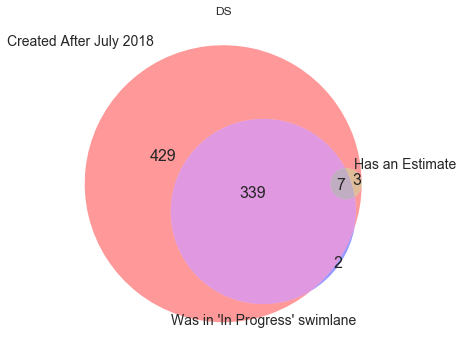

Estimate but never In Progress
4676 Integrate nteract data explorer into a vscode webview
4582 It's hard to see where cells begin and end when doing interactive python editing.
3327 Automate GitHub workflow

In Progress but never Estimated
4733 CTRL+1/2 doesn't set the focus to the input box for the 'Python Interactive' window
4718 Enter telemetry around imports from python files
4716 Add Manual test cases for Python CTI team
4691 Restart kernel never finishes
4666 If the users has a remote server specified and that server is down we show a hard to diagnose ECONNREFUSED error
4640 Feature request: Allow users to specify default style for matplotlib figures
4636 Add telemetry for shift-enter prompt
4588 When switching interpreters there is no sysinfo printed
4573 Random ECONNREFUSED errors are popping up in the wild
4743 Run All Cells Above and Run To Line should not be shown on the first cell/line
4740 Remove requirements.txt from manual test cases
4532 Shift Enter on a file with cells

In [385]:
plot_measurable_issues("DS", pyds_nopr_issues.values(), verbose=True)

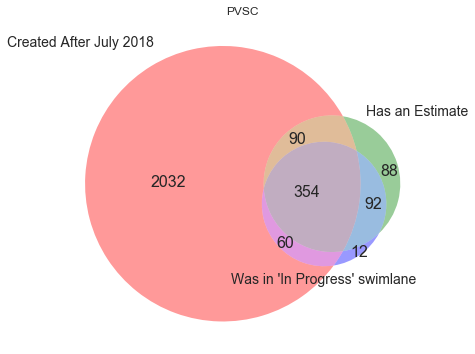

Estimate but never In Progress
4719 Add Collapse all icon for Test explorer
4634 Modify PYTHONPATH when a custom path to Pytest is configured.
4579 Test Explorer contains an unrelated/unnecessary node at the top of the hierarchy.
4745 Test explorer- Tooltip for folder icons not working as expected
4540 Increase timeouts for loading of extension on CI
4490 Deal with `npm audit` warnings
4484 Disable autocompletion in unclosed docstring
4368 Spike on use of environmental variables defined in '.env' file
4366 Spike on Django unit tests support
4235 Spike on environment activation with poetry
4231 Spike on unit test failures to problems window
4210 Bundle job on Travis CI is broken
4203 Debugging fails when using a pipenv environment that gets activated with `pipenv shell`
4034 Azdo CI to run python tests
3896 Publish code coverage reports even if CI fails
3845 Disable prompt used to generate debug configuration
3781 Remove server folder from src directory
3746 Add support to detect xonsh 

In [386]:
plot_measurable_issues("PVSC", pyvsc_nopr_issues.values(), verbose=True)

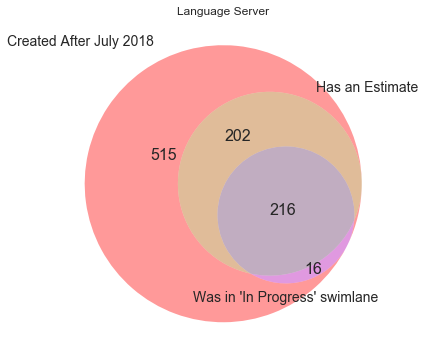

Estimate but never In Progress
734 local variables don't show up in completion
704 Defer all completion documentation creation until completionItem/resolve
688 Add basic progress reporting to analysis
682 Implement tracking variable values by location
669 VSCode reporting unresolved import on local package
652 Remove database search path cache file
645 Peeking References for a extended class
643 Hide type hints in tooltips when they are too long
639 Implement detection of undefined variables
636 Racy completion shows completions from the wrong scope
599 InvalidOperationException in PathResolverSnapshot.TryFindModule
592 Assignments with type hints are not indexed
581 LS: Output lint-level diagnostics
574 Handle relative imports in stubs
571 New LS bug finding / testing
549 Rebuild PythonType to tooltip generation
541 Python unresolved import issue
540 Port imports test to new analysis
537 PTH files support
535 Additional typing specialization
533 Use typeshed for builtins rather than t

In [387]:
plot_measurable_issues("Language Server", pyls_nopr_issues.values(), verbose=True)

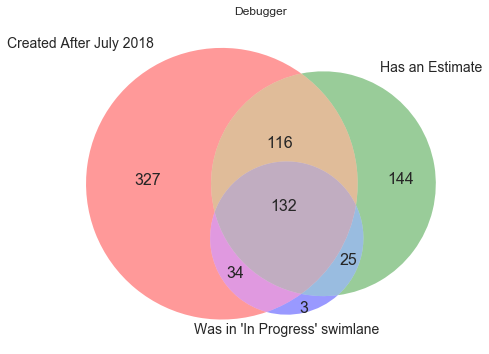

Estimate but never In Progress
1224 pydevd initialization, debug options, and settings using json or CLI
1208 Infinite recursion in pydevd messaging
1202 Error seen on disconnect from remote machine
1175 Provide better shutdown procedure for daemon threads to avoid catch-all exceptions.
1138 Call stack  in Debug panel only shows 20 frames.
1124 Breakpoint with Unicode chars in filename doesn't work in 3.5
1117 Debugger compliance for c++ parts
1110 Map remoteRoot to current working directory if it is '.'
1103 Build wheels for macOS
1089 Test runs on windows running with Tox are timing out
1087 breakpoint() function breaks on different lines on different platforms
1066 Fetching remote source for a file with a Unicode name fails on 2.7
1059 pydev debugger: warning: trying to add breakpoint to file that does not exist:
1058 Unable to debug an OpenAI baselines pipeline task
1054 Migrate to pytests part 3
1047 Support both expression and log breakpoints
1037 Setting breakpoint fails on Pyth

In [388]:
plot_measurable_issues("Debugger", pydbg_nopr_issues.values(), verbose=True)

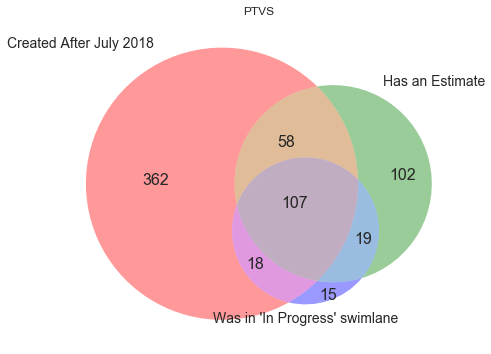

In [389]:
plot_measurable_issues("PTVS", pyvs_nopr_issues.values())

In [390]:
print("Data Science")
analyze(pyds_nopr_issues.values())

Data Science
Events: {'unsubscribed', 'assigned', 'unlocked', 'unassigned', 'subscribed', 'locked', 'closed', 'referenced', 'demilestoned', 'reopened', 'unlabeled', 'moved', 'labeled', 'comment', 'estimated', 'mentioned', 'renamed', 'marked_as_duplicate', 'comment_deleted', 'milestoned'}
Milestones: {'DS Dec 2018', 'DS Feb 2019', '2019, week 15 - April Sprint 8', 'June 2018', '2019, week 11 - March Sprint 6', 'April 2018', 'September 2018 Sprint 1', 'March 2018', '2019 - May Sprint 11', 'DS Nov 2018', 'May 2018', '2019, week 3 - Jan Sprint 2', '2019, week 1 - Jan Sprint 1', 'January 2018', 'February 2018', '2018, week 48 - Dec sprint 1'}
Swimlanes: {'Data Science Parking Lot', 'Validate', 'Data Science', 'Parking Lot', 'Parking lot', 'Sign-Off', 'Backlog', 'Decide', 'Upstream', 'Review', 'New Issues', 'In Progress'}
Labels: {'feature-debugging', 'P2', 'help wanted', 'good first issue', 'type-code health', 'reason-preexisting', 'reason-external', 'cause-CI/CD', 'needs upstream fix', 'ne

## Get the issues for which we can generate rich metrics

Turn the issues into the rich decorated versions, and drop those that are missing key data points.

In [ ]:
print(f"Language Server (originally {len(pyls_nopr_issues)} issues)")
ls_data = get_issues_data(pyls_nopr_issues.values())

print(f"PTVS (originally {len(pyvs_nopr_issues)} issues)")
ptvs_data = get_issues_data(pyvs_nopr_issues.values())

print(f"VSC (originally {len(pyvsc_nopr_issues)} issues)")
vsc_data = get_issues_data(pyvsc_nopr_issues.values())

print(f"Debugger (originally {len(pydbg_nopr_issues)} issues)")
dbg_data = get_issues_data(pydbg_nopr_issues.values())

print(f"Data Science (originally {len(pyds_nopr_issues)} issues)")
ds_data = get_issues_data(pyds_nopr_issues.values())

## Look at cycle time vs estimates

In [639]:
plot_cycletime_vs_points("PVSC", vsc_data, date(2018, 6, 1), date(2019, 1, 1))

PVSC: issue 3321 has >50 cycle time
PVSC: issue 3201 has >50 cycle time
PVSC: issue 3017 has >50 cycle time
PVSC: issue 2722 has >50 cycle time
PVSC: issue 2706 has >50 cycle time
PVSC: issue 2671 has >50 cycle time
PVSC: issue 2221 has >50 cycle time
PVSC: issue 2151 has >50 cycle time


In [640]:
plot_cycletime_vs_points("PVSC", vsc_data, date(2019, 1, 1), date(2019, 7, 1))

PVSC: issue 4035 has >50 cycle time
PVSC: issue 5271 has >50 cycle time


Conclusion for PVSC: we're doing a good job of making small storypointed estimates, but we do have some items that are still taking a while. Need to dig into that more to understand why.

In [641]:
plot_cycletime_vs_points("Language Server", ls_data, date(2018, 6, 1), date(2019, 1, 1))

Language Server: issue 466 has >50 cycle time
Language Server: issue 433 has >50 cycle time
Language Server: issue 386 has >50 cycle time
Language Server: issue 360 has >50 cycle time
Language Server: issue 330 has >50 cycle time
Language Server: issue 309 has >50 cycle time
Language Server: issue 300 has >50 cycle time
Language Server: issue 288 has >50 cycle time
Language Server: issue 279 has >50 cycle time
Language Server: issue 224 has >50 cycle time
Language Server: issue 223 has >50 cycle time
Language Server: issue 222 has >50 cycle time
Language Server: issue 221 has >50 cycle time
Language Server: issue 218 has >50 cycle time
Language Server: issue 186 has >50 cycle time
Language Server: issue 170 has >50 cycle time
Language Server: issue 108 has >50 cycle time
Language Server: issue 107 has >50 cycle time
Language Server: issue 46 has >50 cycle time
Language Server: issue 32 has >50 cycle time
Language Server: issue 29 has >50 cycle time
Language Server: issue 24 has >50 cyc

In [642]:
plot_cycletime_vs_points("Language Server", ls_data, date(2019, 1, 1), date(2019, 7, 1))

Language Server: issue 537 has >50 cycle time


Conclusion for Language Server: our estimates have arguably become more accurate but we still have too many large story-pointed items.

In [643]:
plot_cycletime_vs_points("Debugger", dbg_data, date(2018, 6, 1), date(2019, 1, 1))

Debugger: issue 1071 has >50 cycle time
Debugger: issue 1053 has >50 cycle time
Debugger: issue 1052 has >50 cycle time
Debugger: issue 988 has >50 cycle time
Debugger: issue 923 has >50 cycle time
Debugger: issue 906 has >50 cycle time
Debugger: issue 898 has >50 cycle time
Debugger: issue 863 has >50 cycle time
Debugger: issue 678 has >50 cycle time
Debugger: issue 551 has >50 cycle time
Debugger: issue 548 has >50 cycle time
Debugger: issue 488 has >50 cycle time
Debugger: issue 482 has >50 cycle time


In [644]:
plot_cycletime_vs_points("Debugger", dbg_data, date(2019, 1, 1), date(2019, 7, 1))

Debugger: issue 1224 has >50 cycle time
Debugger: issue 1092 has >50 cycle time


Conclusion for debugger: we seem to be doing better at our estimates but our overall velocity may have slowed (may be a consequence of the earlier filtering though).

In [645]:
plot_cycletime_vs_points("PTVS", ptvs_data, date(2018, 6, 1), date(2019, 1, 1))

PTVS: issue 4888 has >50 cycle time
PTVS: issue 4809 has >50 cycle time
PTVS: issue 4778 has >50 cycle time
PTVS: issue 4359 has >50 cycle time


In [646]:
plot_cycletime_vs_points("PTVS", ptvs_data, date(2019, 1, 1), date(2019, 7, 1))

PTVS: issue 5002 has >50 cycle time
PTVS: issue 4975 has >50 cycle time
PTVS: issue 5288 has >50 cycle time
PTVS: issue 5287 has >50 cycle time
PTVS: issue 5286 has >50 cycle time
PTVS: issue 5285 has >50 cycle time
PTVS: issue 5284 has >50 cycle time
PTVS: issue 5283 has >50 cycle time
PTVS: issue 5282 has >50 cycle time


Seem to be doing okay on PTVS with estimates.

Conclusion for data science team: maybe do estimates!

Now we'll do a different view. For any story point value for which we have at least 7 samples, drop outliers and plot quartiles.

In [647]:
plot_estimates("PVCS", [i for i in vsc_data if i.storypoints and i.has_in_progress_event], date(2018, 6, 1), date(2019, 1, 1))

PVCS: issue 3321 has >50 cycle time
PVCS: issue 3201 has >50 cycle time
PVCS: issue 2722 has >50 cycle time


In [648]:
plot_estimates("PVCS", [i for i in vsc_data if i.storypoints and i.has_in_progress_event], date(2019, 1, 1), date(2019, 7, 1))

PVCS: issue 4035 has >50 cycle time


In [649]:
plot_estimates("LS", [i for i in ls_data if i.storypoints and i.has_in_progress_event], date(2018, 6, 1), date(2019, 1, 1))

LS: issue 466 has >50 cycle time
LS: issue 386 has >50 cycle time
LS: issue 107 has >50 cycle time
LS: issue 32 has >50 cycle time
LS: issue 29 has >50 cycle time
LS: issue 6 has >50 cycle time
LS: issue 5 has >50 cycle time


In [650]:
plot_estimates("LS", [i for i in ls_data if i.storypoints and i.has_in_progress_event], date(2019, 1, 1), date(2019, 7, 1))

In [651]:
plot_estimates("Debugger", [i for i in dbg_data if i.storypoints], date(2018, 6, 1), date(2019, 1, 1))

Debugger: issue 1053 has >50 cycle time
Debugger: issue 1052 has >50 cycle time
Debugger: issue 988 has >50 cycle time
Debugger: issue 923 has >50 cycle time
Debugger: issue 906 has >50 cycle time
Debugger: issue 898 has >50 cycle time
Debugger: issue 863 has >50 cycle time
Debugger: issue 678 has >50 cycle time
Debugger: issue 551 has >50 cycle time
Debugger: issue 548 has >50 cycle time
Debugger: issue 488 has >50 cycle time
Debugger: issue 482 has >50 cycle time


In [652]:
plot_estimates("Debugger", [i for i in dbg_data if i.storypoints ], date(2019, 1, 1), date(2019, 7, 1))

Debugger: issue 1224 has >50 cycle time
Debugger: issue 1092 has >50 cycle time


In [653]:
plot_estimates("PTVS", [i for i in ptvs_data if i.storypoints], date(2018, 6, 1), date(2019, 1, 1))

PTVS: issue 4888 has >50 cycle time
PTVS: issue 4809 has >50 cycle time
PTVS: issue 4778 has >50 cycle time
PTVS: issue 4359 has >50 cycle time


In [654]:
plot_estimates("PTVS", [i for i in ptvs_data if i.storypoints], date(2019, 1, 1), date(2019, 7, 1))

PTVS: issue 5002 has >50 cycle time
PTVS: issue 4975 has >50 cycle time
PTVS: issue 5288 has >50 cycle time
PTVS: issue 5287 has >50 cycle time
PTVS: issue 5286 has >50 cycle time
PTVS: issue 5285 has >50 cycle time
PTVS: issue 5284 has >50 cycle time
PTVS: issue 5283 has >50 cycle time
PTVS: issue 5282 has >50 cycle time


## Lead Time and Cycle Time

In [655]:
start = date(2019, 1, 1)
end = date(2019, 7, 1)
lead_title = "Lead Time (Days)"
cycle_title = "Cycle Time (Days)"

lead_pvsc = plot_metric("PVSC", [i for i in vsc_data if i.storypoints], 
                        lead_title, get_lead_time, start, end)
lead_ls = plot_metric("Language Server", [i for i in ls_data if i.storypoints], 
                      lead_title, get_lead_time, start, end)
lead_dbg = plot_metric("Debugger", [i for i in dbg_data if i.storypoints], 
                       lead_title, get_lead_time, start, end)
lead_ptvs = plot_metric("PTVS", [i for i in ptvs_data if i.storypoints], 
                        lead_title, get_lead_time, start, end)
lead_ds = plot_metric("Data Science", ds_data, lead_title, get_lead_time, start, end)

lead_title = "Lead Time (Days) for Bugs"

lead_pvsc_bugs = plot_metric("PVSC", [i for i in vsc_data if i.storypoints and i.is_bug], 
                             lead_title, get_lead_time, start, end)
lead_ls_bugs = plot_metric("Language Server", [i for i in ls_data if i.storypoints and i.is_bug], 
                           lead_title, get_lead_time, start, end)
lead_dbg_bugs = plot_metric("Debugger", [i for i in dbg_data if i.storypoints and i.is_bug], 
                            lead_title, get_lead_time, start, end)
lead_ptvs_bugs = plot_metric("PTVS", [i for i in ptvs_data if i.storypoints and i.is_bug], 
                             lead_title, get_lead_time, start, end)
lead_ds_bugs = plot_metric("Data Science", [i for i in ds_data if i.is_bug], 
                           lead_title, get_lead_time, start, end)

lead_title = "Lead Time (Days) for Features"
lead_pvsc_features= plot_metric("PVSC", [i for i in vsc_data if i.storypoints and not i.is_bug], 
                            lead_title, get_lead_time, start, end)
lead_ls_features = plot_metric("Language Server", [i for i in ls_data if i.storypoints and not i.is_bug], 
                          lead_title, get_lead_time, start, end)
lead_dbg_features = plot_metric("Debugger", [i for i in dbg_data if i.storypoints and not i.is_bug], 
                           lead_title, get_lead_time, start, end)
lead_ptvs_features = plot_metric("PTVS", [i for i in ptvs_data if i.storypoints and not i.is_bug], 
                            lead_title, get_lead_time, start, end)
lead_ds_features = plot_metric("Data Science", [i for i in ds_data if not i.is_bug], 
                          lead_title, get_lead_time, start, end)

cycle_pvsc = plot_metric("PVSC", [i for i in vsc_data if i.storypoints], 
                         cycle_title, get_cycle_time, start, end)
cycle_ls = plot_metric("Language Server", [i for i in ls_data if i.storypoints],
                                           cycle_title, get_cycle_time, start, end)
cycle_dbg = plot_metric("Debugger", [i for i in dbg_data if i.storypoints], 
                        cycle_title, get_cycle_time, start, end)
cycle_ptvs = plot_metric("PTVS", [i for i in ptvs_data if i.storypoints], 
                         cycle_title, get_cycle_time, start, end)
cycle_ds = plot_metric("Data Science", ds_data, cycle_title, get_cycle_time, start, end)

PVSC: issue 4035 has >50 cycle time
PVSC: issue 5271 has >50 cycle time
Language Server: issue 537 has >50 cycle time
Debugger: issue 1224 has >50 cycle time
Debugger: issue 1092 has >50 cycle time
PTVS: issue 5002 has >50 cycle time
PTVS: issue 4975 has >50 cycle time
PTVS: issue 5288 has >50 cycle time
PTVS: issue 5287 has >50 cycle time
PTVS: issue 5286 has >50 cycle time
PTVS: issue 5285 has >50 cycle time
PTVS: issue 5284 has >50 cycle time
PTVS: issue 5283 has >50 cycle time
PTVS: issue 5282 has >50 cycle time
Data Science: issue 4348 has >50 cycle time
Data Science: issue 4290 has >50 cycle time
Data Science: issue 4255 has >50 cycle time
Data Science: issue 4237 has >50 cycle time
Data Science: issue 4206 has >50 cycle time
Data Science: issue 4184 has >50 cycle time
Data Science: issue 4084 has >50 cycle time
Data Science: issue 4081 has >50 cycle time
Data Science: issue 4065 has >50 cycle time
Data Science: issue 4057 has >50 cycle time
Data Science: issue 4010 has >50 cycle

In [656]:
show(gridplot([[lead_pvsc, cycle_pvsc], [lead_pvsc_bugs, lead_pvsc_features]]))

In [657]:
show(gridplot([[lead_ls, cycle_ls], [lead_ls_bugs, lead_ls_features]]))

In [658]:
show(gridplot([[lead_dbg, cycle_dbg], [lead_dbg_bugs, lead_dbg_features]]))

In [659]:
show(gridplot([[lead_ptvs, cycle_ptvs], [lead_ptvs_bugs, lead_ptvs_features]]))

In [660]:
show(gridplot([[lead_ds, cycle_ds], [lead_ds_bugs, lead_ds_features]]))

In [672]:
start = date(2019, 1, 1)
end = date(2019, 7, 1)
p1 = plot_metric("PVSC", vsc_data, "Cycle Time (Days)", lambda x: x.cycle_time_days, start, end)
p2 = plot_metric("Language Server", ls_data, "Cycle Time (Days)", lambda x: x.cycle_time_days, start, end)
p3 = plot_metric("Debugger", dbg_data, "Cycle Time (Days)", lambda x: x.cycle_time_days, start, end)
p4 = plot_metric("PTVS", ptvs_data, "Cycle Time (Days)", lambda x: x.cycle_time_days, start, end)
show(gridplot([[p1, p2], [p3, p4]]))

PVSC: issue 4035 has >50 cycle time
PVSC: issue 5271 has >50 cycle time
Language Server: issue 537 has >50 cycle time
Debugger: issue 1224 has >50 cycle time
Debugger: issue 1092 has >50 cycle time
PTVS: issue 5002 has >50 cycle time
PTVS: issue 4975 has >50 cycle time
PTVS: issue 5288 has >50 cycle time
PTVS: issue 5287 has >50 cycle time
PTVS: issue 5286 has >50 cycle time
PTVS: issue 5285 has >50 cycle time
PTVS: issue 5284 has >50 cycle time
PTVS: issue 5283 has >50 cycle time
PTVS: issue 5282 has >50 cycle time


In [696]:
from bokeh.layouts import gridplot

p1 = plot_mean_time("PVSC", vsc_data, lambda x: x.lead_time_days, "Lead Times", start=start)
p2 = plot_mean_time("LS", ls_data, lambda x: x.lead_time_days, "Lead Times", start=start)
p3 = plot_mean_time("DBG", dbg_data, lambda x: x.lead_time_days, "Lead Times", start=start)
p4 = plot_mean_time("PTVS", ptvs_data, lambda x: x.lead_time_days, "Lead Times", start=start)
ds = plot_mean_time("DS", ds_data, lambda x: x.lead_time_days, "Lead Times", start=start)

show(gridplot([[p1, p2, ds], [p3, p4]]))

PVSC: issue 4035 has >50 cycle time
PVSC: issue 5271 has >50 cycle time
LS: issue 537 has >50 cycle time
DBG: issue 1092 has >50 cycle time
DBG: issue 1224 has >50 cycle time
PTVS: issue 5002 has >50 cycle time
PTVS: issue 4975 has >50 cycle time
PTVS: issue 5288 has >50 cycle time
PTVS: issue 5287 has >50 cycle time
PTVS: issue 5286 has >50 cycle time
PTVS: issue 5285 has >50 cycle time
PTVS: issue 5284 has >50 cycle time
PTVS: issue 5283 has >50 cycle time
PTVS: issue 5282 has >50 cycle time
DS: issue 4237 has >50 cycle time
DS: issue 4206 has >50 cycle time
DS: issue 4184 has >50 cycle time
DS: issue 4084 has >50 cycle time
DS: issue 4081 has >50 cycle time
DS: issue 4065 has >50 cycle time
DS: issue 4057 has >50 cycle time
DS: issue 4010 has >50 cycle time
DS: issue 3981 has >50 cycle time
DS: issue 4348 has >50 cycle time
DS: issue 4290 has >50 cycle time
DS: issue 4255 has >50 cycle time


In [697]:
from bokeh.layouts import gridplot

p1 = plot_mean_time("PVSC", vsc_data, lambda x: x.cycle_time_days, "Cycle Times", start=start)
p2 = plot_mean_time("LS", ls_data, lambda x: x.cycle_time_days, "Cycle Times", start=start)
p3 = plot_mean_time("DBG", dbg_data, lambda x: x.cycle_time_days, "Cycle Times", start=start)
p4 = plot_mean_time("PTVS", ptvs_data, lambda x: x.cycle_time_days, "Cycle Times", start=start)
show(gridplot([[p1, p2], [p3, p4]]))

PVSC: issue 4035 has >50 cycle time
PVSC: issue 5271 has >50 cycle time
LS: issue 537 has >50 cycle time
DBG: issue 1092 has >50 cycle time
DBG: issue 1224 has >50 cycle time
PTVS: issue 5002 has >50 cycle time
PTVS: issue 4975 has >50 cycle time
PTVS: issue 5288 has >50 cycle time
PTVS: issue 5287 has >50 cycle time
PTVS: issue 5286 has >50 cycle time
PTVS: issue 5285 has >50 cycle time
PTVS: issue 5284 has >50 cycle time
PTVS: issue 5283 has >50 cycle time
PTVS: issue 5282 has >50 cycle time


In [682]:
p1 = plot_WIP_quartiles("VSC", [i for i in vsc_data if i.storypoints], start, end)
p2 = plot_WIP_quartiles("Language Server", [i for i in ls_data if i.storypoints], start, end)
p3 = plot_WIP_quartiles("Debugger", [i for i in dbg_data if i.storypoints], start, end)
p4 = plot_WIP_quartiles("PTVS", [i for i in ptvs_data if i.storypoints], start, end)
ds = plot_WIP_quartiles("Data Science", ds_data, start, end)
show(gridplot([[p1, p2, ds], [p3, p4]]))

In [698]:
p1 = plot_WIP_mean("VSC",  [i for i in vsc_data if i.storypoints], start, end)
p2 = plot_WIP_mean("Language Server",  [i for i in ls_data if i.storypoints], start, end)
p3 = plot_WIP_mean("Debugger",  [i for i in dbg_data if i.storypoints], start, end)
p4 = plot_WIP_mean("PTVS",  [i for i in ptvs_data if i.storypoints], start, end)
ds = plot_WIP_mean("DS", ds_data, start, end)
show(gridplot([[p1, p2, ds], [p3, p4]]))

In [425]:
p1 = plot_WIP_mean("VSC", get_issues_with_in_progress(vsc_data))
p2 = plot_WIP_mean("Language Server", get_issues_with_in_progress(ls_data))
p3 = plot_WIP_mean("Debugger", get_issues_with_in_progress(dbg_data))
p4 = plot_WIP_mean("PTVS", get_issues_with_in_progress(ptvs_data))
show(gridplot([[p1, p2], [p3, p4]]))

Starting with 553 closed issues
400 issues created on or after Aug 1, 2018
327 have moved In Progress
Filtered to 327 issues
Starting with 354 closed issues
354 issues created on or after Aug 1, 2018
219 have moved In Progress
Filtered to 219 issues
Starting with 400 closed issues
251 issues created on or after Aug 1, 2018
160 have moved In Progress
Filtered to 160 issues
Starting with 246 closed issues
149 issues created on or after Aug 1, 2018
116 have moved In Progress
Filtered to 116 issues


## Github Response Turnaround

In [594]:
ls_full_data = get_issues_data(pyls_nopr_issues.values(), skip_invalid=False)
ptvs_full_data = get_issues_data(pyvs_nopr_issues.values(), skip_invalid=False)
vsc_full_data = get_issues_data(pyvsc_nopr_issues.values(), skip_invalid=False)
dbg_full_data = get_issues_data(pydbg_nopr_issues.values(), skip_invalid=False)
ds_full_data = get_issues_data(pyds_nopr_issues.values(), skip_invalid=False)
aml_full_data = get_issues_data(aml_nopr_issues.values(), skip_invalid=False)
mb_full_data = get_issues_data(mb_nopr_issues.values(), skip_invalid=False)

In [471]:
plot_response_times("PVSC", vsc_full_data, date(2019, 7, 1), date(2019, 8, 1))

6706 has no comment or has response time of -1
6693 has no comment or has response time of -1
6615 has no comment or has response time of -1
6557 has no comment or has response time of -1
6556 has no comment or has response time of -1
6513 has no comment or has response time of -1
6483 has no comment or has response time of -1
6407 has no comment or has response time of -1
6806 has no comment or has response time of -1
6787 has no comment or has response time of -1
6784 has no comment or has response time of -1
6765 has no comment or has response time of -1
12


In [472]:
plot_response_times("Debugger", dbg_full_data, date(2019, 7, 1), date(2019, 8, 1))

1633 has no comment or has response time of -1
1627 has no comment or has response time of -1
1645 has no comment or has response time of -1
1644 has no comment or has response time of -1
4


In [473]:
plot_response_times("Language Server", ls_full_data, date(2019, 7, 1), date(2019, 8, 1))

1385 has no comment or has response time of -1
1369 has no comment or has response time of -1
1356 has no comment or has response time of -1
1353 has no comment or has response time of -1
1345 has no comment or has response time of -1
1332 has no comment or has response time of -1
1310 has no comment or has response time of -1
1301 has no comment or has response time of -1
1293 has no comment or has response time of -1
1281 has no comment or has response time of -1
1275 has no comment or has response time of -1
1274 has no comment or has response time of -1
1395 has no comment or has response time of -1
13


In [475]:
plot_response_times("PTVS", ptvs_full_data, date(2019, 7, 1), date(2019, 8, 1))

5441 has no comment or has response time of -1
1


In [476]:
plot_response_times("Python Data Science", ds_full_data, date(2019, 7, 1), date(2019, 8, 1))

6668 has no comment or has response time of -1
6663 has no comment or has response time of -1
6560 has no comment or has response time of -1
6804 has no comment or has response time of -1
6759 has no comment or has response time of -1
6748 has no comment or has response time of -1
6


In [595]:
plot_response_times("AzureML Extension", aml_full_data, date(2019, 7, 1), date(2019, 8, 1))

0


In [596]:
plot_response_times("Model Builder", mb_full_data, date(2019, 7, 1), date(2019, 8, 1))

197 has no comment or has response time of -1
192 has no comment or has response time of -1
191 has no comment or has response time of -1
147 has no comment or has response time of -1
4


## Active Bug Rates

In [564]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), pyvsc_issues.values(), "Data Science", 
              ["type-bug", "data science"], interval=1)

In [565]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), pyvsc_issues.values(), "PVSC", 
              ["type-bug", "needs PR"], ["data science"], interval=1)

In [568]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), pyls_issues.values(), "Language Server", 
              ["bug"], interval=1)

In [569]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), pydbg_issues.values(), "Debugger", 
              ["Bug"], interval=1)

In [570]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), pyvs_issues.values(), "PTVS", 
              ["bug"], interval=1)

In [590]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), aml_issues.values(), "AzureML Ext", 
              ["bug"], interval=1)

In [591]:
plot_bug_rate(datetime(2019, 6, 1), datetime(2019, 8, 1), mb_issues.values(), "Model Builder", 
              ["bug"], interval=1)